# Recommendation System

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import json
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import seaborn as sns
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt7
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import operator
from sklearn.metrics import jaccard_score

# Data visualization and preprocessing

In [2]:
movie = pd.read_csv('data/movies.csv')

In [3]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
#is any row null
movie.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [5]:
#number of unique movies
movies_l = movie['movieId'].unique().tolist()
len(movies_l)

9742

In [6]:
# lets explore ratings.CSV
ratings_data=pd.read_csv('data/ratings.csv',sep=',')
ratings_data.shape

(100836, 4)

In [7]:
 ratings_data.drop(['timestamp'], axis=1, inplace=True)

In [8]:
ratings_data.head() #displays first 5 entries 

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [9]:
#is any row null there
ratings_data.isnull().any()

userId     False
movieId    False
rating     False
dtype: bool

In [10]:
#minimum rating given to a movie
ratings_data['rating'].min()

0.5

In [11]:
#maximum rating given to a movie
ratings_data['rating'].max()

5.0

In [12]:
# filtering to get the list of drama movies
drama_movies=movie['genres'].str.contains('Drama')
movie[drama_movies].head()

,movieId,title,genres
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
10,11,"American President, The (1995)",Comedy|Drama|Romance
13,14,Nixon (1995),Drama
15,16,Casino (1995),Crime|Drama
16,17,Sense and Sensibility (1995),Drama|Romance


In [13]:
#total number of drama movies
drama_movies.shape

(9742,)

In [14]:
#filtering to get the list of comedy movies
comedy_movies = movie['genres'].str.contains('Comedy')
movie[comedy_movies].head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
6,7,Sabrina (1995),Comedy|Romance


In [15]:
#total no. of comedy movies
comedy_movies.shape

(9742,)

# The correlation between the ratings of a movie as the similarity metric.

In [16]:
movie_data = pd.merge(ratings_data, movie, on='movieId')
movie_data.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [17]:
# Now let's take a look at the average rating of each movie. 
movie_data.groupby('title')['rating'].mean().head()

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

In [18]:
# Let's sort the average ratings according to the ascending order :
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

In [19]:
# Let's now plot the total number of ratings for a movie:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [20]:
# create ratings_mean_count dataframe and first add the average rating of each movie:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())

In [21]:
# add the number of ratings for a movie to the ratings_mean_count dataframe:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())

In [22]:
ratings_mean_count.head()

,rating,rating_counts
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [23]:
# To find the correlation between the ratings of the movie, we need to create a matrix
#where each column is a movie name and each row contains the rating 
#assigned by a specific user to that movie.

user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# we want to find the correlation between movies that have a higher number of ratings:
Forrest_Gump_ratings = user_movie_rating[user_movie_rating['Forrest Gump (1994)']>=4]
Forrest_Gump_ratings.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#  We can find the correlation between the user ratings for the "hamlet" 
#and all the other movies using corrwith():

movies_like_Forrest = user_movie_rating.corrwith(Forrest_Gump_ratings )

corr_Forrest = pd.DataFrame(movies_like_Forrest, columns=['Correlation'])
corr_Forrest.dropna(inplace=True)
corr_Forrest.head()

,Correlation
title,
"'burbs, The (1989)",1.0
(500) Days of Summer (2009),1.0
*batteries not included (1987),1.0
...And Justice for All (1979),1.0
10 Cloverfield Lane (2016),1.0


In [26]:
# sort the movies in descending order of correlation to see highly correlated movies at the top.
corr_Forrest.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
"Village, The (2004)",1.0
Judge Dredd (1995),1.0
Natural Born Killers (1994),1.0
Flight of the Navigator (1986),1.0
Supergirl (1984),1.0
Forget Paris (1995),1.0
"Matrix, The (1999)",1.0
"Triplets of Belleville, The (Les triplettes de Belleville) (2003)",1.0
"Forgotten, The (2004)",1.0


In [27]:
corr_Forrest = corr_Forrest.join(ratings_mean_count['rating_counts'])
corr_Forrest.head()

,Correlation,rating_counts
title,,
"'burbs, The (1989)",1.0,17
(500) Days of Summer (2009),1.0,42
*batteries not included (1987),1.0,7
...And Justice for All (1979),1.0,3
10 Cloverfield Lane (2016),1.0,14


In [28]:
# Let's now filter movies correlated to "hamlet", that have more than 50 ratings.
corr_Forrest[corr_Forrest ['rating_counts']>50].sort_values('Correlation', ascending=False).head()

,Correlation,rating_counts
title,,
Judge Dredd (1995),1.0,62
Natural Born Killers (1994),1.0,92
Sleepless in Seattle (1993),1.0,106
"Christmas Story, A (1983)",1.0,55
Signs (2002),1.0,63


In [29]:
# Belal

# Add more features 

**Dataset sources**

 1- https://www.kaggle.com/rounakbanik/the-movies-dataset/data#movies_metadata.csv
    - contains metadat about around 45000 movies named as larag_movies.
 2- https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset/data?fbclid=IwAR1aLctv4w9jvh5SXc3powOPdFhu8kM83RzUlPXqW9PC1wIele0YlluIcE
    - contains metadata around 5000 movies named as small_movies.
 3- https://grouplens.org/datasets/movielens/
    - contains movies names around 27000 movies named as medium_movies.
    
* We will work with construct new database from these resource to gain more features and due to low resources to run 
  this reducing the dataset is a good solution.

In [123]:
# Read data first
small_movies = pd.read_csv('data/movies_metadata_small.csv')
large_movies = pd.read_csv("data/movies_metadata_large.csv")
medium_movies = pd.read_csv("data/movies_2.csv")

/home/belal/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Small dataset

In [124]:
# Let's explore each dataset as follows
small_movies.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [125]:
small_movies.shape

(5043, 28)

In [126]:
small_movies.isna().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

# Large dataset

In [127]:
# Let's explore each dataset as follows
large_movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [128]:
large_movies.shape

(45466, 24)

In [129]:
large_movies.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

# Medium dataset

In [130]:
medium_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [131]:
medium_movies.shape

(27278, 3)

In [132]:
medium_movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

# Dataset construction

**1 - Getting the movie ids from merging small and medium dataset.**
   - joing will be based on movie name so we need the two table to have column with the same name, and the name itself must be in lowercase.

In [133]:
# Pre-processing on medium dataset.

# spliting the year of the movie from the name of the movie.
# Finding substring like (2019) to extract and store it in another column.
medium_movies['year'] = medium_movies['title'].apply(lambda x: re.findall('([0-9]+)', x)[-1] if re.findall('([0-9]+)', x) else None)

# Replacing substring like (2019) by '', then lowercase the movie name finally 
# removing spaces at the end of the movie name.
medium_movies['clean_title'] = medium_movies['title'].apply(lambda x: x.replace(re.findall('\([0-9]+\)', x)[-1], '').rstrip().lower() if re.findall('\([0-9]+\)', x) else x)

medium_movies.isna().sum()

movieId         0
title           0
genres          0
year           18
clean_title     0
dtype: int64

In [134]:
# Pre-processing on small dataset.

# 1- lowercase the movie name.
small_movies['movie_title'] = small_movies['movie_title'].apply(lambda x: x.rstrip().lower())

# 2- rename 'movie_title' to 'title'
small_movies = small_movies.rename(columns={"movie_title": "clean_title"})

In [135]:
small_medium_movies = pd.merge(small_movies, medium_movies, on=['clean_title'], how='inner')
small_medium_movies

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres_x,...,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,movieId,title,genres_y,year
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,237000000.0,2009.0,936.0,7.9,1.78,33000,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,2009
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,300000000.0,2007.0,5000.0,7.1,2.35,0,53125,Pirates of the Caribbean: At World's End (2007),Action|Adventure|Comedy|Fantasy,2007
2,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,263700000.0,2012.0,632.0,6.6,2.35,24000,93363,John Carter (2012),Action|Adventure|Sci-Fi|IMAX,2012
3,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,258000000.0,2007.0,11000.0,6.2,2.35,0,52722,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX,2007
4,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,258000000.0,2007.0,11000.0,6.2,2.35,0,52722,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,Color,Ash Baron-Cohen,10.0,98.0,3.0,152.0,Stanley B. Herman,789.0,NaN,Crime|Drama,...,NaN,1995.0,194.0,6.4,NaN,20,1697,Bang (1995),Crime|Drama,1995
3620,Color,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,424760.0,Drama|Sci-Fi|Thriller,...,7000.0,2004.0,45.0,7.0,1.85,19000,8914,Primer (2004),Drama|Sci-Fi,2004
3621,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,...,9000.0,2011.0,205.0,6.4,NaN,413,91829,Newlyweds (2011),Drama,2011
3622,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,NaN,2012.0,719.0,6.3,2.35,660,101294,Shanghai Calling (2012),Comedy|Drama|Romance,2012


**Now the shape of the result from the joining tow dataset is.**

In [136]:
print(small_medium_movies.shape)

(3624, 32)


In [137]:
small_medium_movies.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres_x', 'actor_1_name',
       'clean_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'movieId',
       'title', 'genres_y', 'year'],
      dtype='object')

**genres_x and genres_y is not the same.**
 - so we'll concancate the tow genres into one column and call it genre. 

In [138]:
def concancate_genres(row):
    genres = set(row['genres_x'].split("|") + row['genres_y'].split("|"))
    return '|'.join(genres)
small_medium_movies['genres'] = small_medium_movies.apply(concancate_genres, axis=1)
small_medium_movies

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres_x,...,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,movieId,title,genres_y,year,genres
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,2009.0,936.0,7.9,1.78,33000,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,2009,Action|Adventure|Sci-Fi|IMAX|Fantasy
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,2007.0,5000.0,7.1,2.35,0,53125,Pirates of the Caribbean: At World's End (2007),Action|Adventure|Comedy|Fantasy,2007,Adventure|Comedy|Fantasy|Action
2,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,2012.0,632.0,6.6,2.35,24000,93363,John Carter (2012),Action|Adventure|Sci-Fi|IMAX,2012,Sci-Fi|Adventure|IMAX|Action
3,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,2007.0,11000.0,6.2,2.35,0,52722,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX,2007,Action|Adventure|Sci-Fi|Romance|Thriller|IMAX
4,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,2007.0,11000.0,6.2,2.35,0,52722,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX,2007,Action|Adventure|Sci-Fi|Romance|Thriller|IMAX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,Color,Ash Baron-Cohen,10.0,98.0,3.0,152.0,Stanley B. Herman,789.0,NaN,Crime|Drama,...,1995.0,194.0,6.4,NaN,20,1697,Bang (1995),Crime|Drama,1995,Drama|Crime
3620,Color,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,424760.0,Drama|Sci-Fi|Thriller,...,2004.0,45.0,7.0,1.85,19000,8914,Primer (2004),Drama|Sci-Fi,2004,Sci-Fi|Thriller|Drama
3621,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,...,2011.0,205.0,6.4,NaN,413,91829,Newlyweds (2011),Drama,2011,Comedy|Drama
3622,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,2012.0,719.0,6.3,2.35,660,101294,Shanghai Calling (2012),Comedy|Drama|Romance,2012,Romance|Comedy|Drama


**2 - Now, let's add more features from the 'large_movies' dataset, features are:**

    -budget.
    -revenu.
    -popularity.
    -original_title.
    -title -- to merge by.

In [139]:
# Define columns we need to add.
selected_columns = ['budget', 'original_title', 'popularity', 'revenue', 'title']

# Select the dataframe we need to merge on.
large_movies_selected = large_movies[selected_columns]

# Clean the title, remove spaces and conert its type.
large_movies_selected['clean_title'] = large_movies_selected['title'].apply(lambda x: str(x).lower().rstrip())

large_movies['clean_title'] = large_movies_selected['title'].apply(lambda x: str(x).lower().rstrip())

# Merging the dataset on the 'clean_title'
small_medium_large_movies = pd.merge(small_medium_movies, large_movies_selected, on='clean_title', how='inner')

# Dropping duplicate rows.
small_medium_large_movies.drop_duplicates(subset='clean_title', keep='first', inplace=True)

# Printing the new shape.
small_medium_large_movies.shape

/home/belal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(3117, 38)

In [140]:
small_medium_large_movies.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres_x', 'actor_1_name',
       'clean_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget_x', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'movieId',
       'title_x', 'genres_y', 'year', 'genres', 'budget_y', 'original_title',
       'popularity', 'revenue', 'title_y'],
      dtype='object')

**3 - Save the dataset.**
    - Finally save the new version of the dataset and move on the next steps:
        - removing reduant features.
        - Filling NAN values.
        - Transforming the text features to numeric ones.

In [141]:
small_medium_large_movies.to_csv("small_medium_large_movies.csv")

In [142]:
small_medium_large_movies

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres_x,...,movieId,title_x,genres_y,year,genres,budget_y,original_title,popularity,revenue,title_y
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,2009,Action|Adventure|Sci-Fi|IMAX|Fantasy,237000000,Avatar,185.071,2.787965e+09,Avatar
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,53125,Pirates of the Caribbean: At World's End (2007),Action|Adventure|Comedy|Fantasy,2007,Adventure|Comedy|Fantasy|Action,300000000,Pirates of the Caribbean: At World's End,31.3637,9.610000e+08,Pirates of the Caribbean: At World's End
2,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,93363,John Carter (2012),Action|Adventure|Sci-Fi|IMAX,2012,Sci-Fi|Adventure|IMAX|Action,260000000,John Carter,14.6704,2.841391e+08,John Carter
3,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,52722,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX,2007,Action|Adventure|Sci-Fi|Romance|Thriller|IMAX,258000000,Spider-Man 3,27.6143,8.908716e+08,Spider-Man 3
5,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,81847,Tangled (2010),Animation|Children|Comedy|Fantasy|Musical|Roma...,2010,Adventure|Musical|Comedy|Children|Animation|Ro...,260000000,Tangled,14.6848,5.917949e+08,Tangled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,Color,Ash Baron-Cohen,10.0,98.0,3.0,152.0,Stanley B. Herman,789.0,NaN,Crime|Drama,...,1697,Bang (1995),Crime|Drama,1995,Drama|Crime,0,Bang,0.679528,0.000000e+00,Bang
5195,Color,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,424760.0,Drama|Sci-Fi|Thriller,...,8914,Primer (2004),Drama|Sci-Fi,2004,Sci-Fi|Thriller|Drama,7000,Primer,7.15307,4.247600e+05,Primer
5196,Color,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Comedy|Drama,...,91829,Newlyweds (2011),Drama,2011,Comedy|Drama,9000,Newlyweds,1.09048,0.000000e+00,Newlyweds
5197,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,101294,Shanghai Calling (2012),Comedy|Drama|Romance,2012,Romance|Comedy|Drama,0,Shanghai Calling,0.907309,0.000000e+00,Shanghai Calling


# Pre-processing  

**1 - Removing redundant features and features that are not necessary.**


In [143]:
# Let's count NAN values again after constructions.
small_medium_large_movies.isna().sum()

color                          6
director_name                 46
num_critic_for_reviews         3
duration                       1
director_facebook_likes       46
actor_3_facebook_likes         4
actor_2_name                   2
actor_1_facebook_likes         1
gross                        366
genres_x                       0
actor_1_name                   1
clean_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                   4
facenumber_in_poster           2
plot_keywords                 21
movie_imdb_link                0
num_user_for_reviews           0
language                       4
country                        0
content_rating                70
budget_x                     249
title_year                    46
actor_2_facebook_likes         2
imdb_score                     0
aspect_ratio                  88
movie_facebook_likes           0
movieId                        0
title_x                        0
genres_y  

In [144]:
small_medium_large_movies.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres_x                      object
actor_1_name                  object
clean_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget_x                     float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

<h3>Explanation</h3>

**After observing the small_medium_large_movies features dataset, there are some redundant features that will affect our work are:**

 - The redundant features are ['title_year', 'budget_x', 'genres_x', 'title_x'].

 - Features [actor_1_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes] are redundant data as feature 
'cast_total_facebook_likes' is more resonable to represent information about movie.

 - A feature [num_voted_users] is a redundant for a imdb_score.

 - A feature [movie_facebook_likes] can be represented by popularity.
 
 - A feature [gross] is a redundant for revenue.]
 
 - Features [num_critic_for_reviews, num_user_for_reviews] can't understand these two features
 
 - Features like [aspect_ratio] represnts the width of screen, [movie_imdb_link, facenumber_in_poster] make nothing.
 
 - A feature [color] is redundant for year.
 
 - A feature [plot_keywords] should be explored.
 
 - A feature [plot_keywords] has extremely diverse respresentation and you can't depend on it as a structured 
     feature.
 
**The features we stick with:** 

    revenue
    popularity
    budget
    genres
    imdb_score
    year
    country
    language
    cast_total_facebook_likes
    actor_1_name
    actor_2_name
    actor_3_name
    director_name --based on popularity
    content_rating
    
    
**The deleted features will be:**
    
    num_user_for_reviews
    movie_imdb_link
    facenumber_in_poster
    actor_2_facebook_likes
    movie_facebook_likes
    gross
    actor_1_facebook_likes
    actor_3_facebook_likes
    duration
    num_critic_for_reviews
    num_voted_users
    aspect_ratio
    color
    plot_keywords

In [145]:
def select_data(data):
    
    data_f1 = data.drop(['num_user_for_reviews', 'movie_imdb_link', 'facenumber_in_poster', 
                                    'actor_2_facebook_likes', 'movie_facebook_likes', 'gross', 'actor_1_facebook_likes', 
                                    'actor_3_facebook_likes', 'duration', 'num_critic_for_reviews', 'director_facebook_likes',
                                    'num_voted_users', 'aspect_ratio', 'color', 'plot_keywords','title_year', 
                                                                   'budget_x', 'genres_x', 'title_x', 'genres_y'], axis=1, inplace=False)
    data_f1 = data_f1.rename(columns={"budget_y": "budget", 'title_y': 'title'})
    return data_f1

small_medium_large_movies_f1 = select_data(small_medium_large_movies)
small_medium_large_movies_f1.isna().sum()

director_name                46
actor_2_name                  2
actor_1_name                  1
clean_title                   0
cast_total_facebook_likes     0
actor_3_name                  4
language                      4
country                       0
content_rating               70
imdb_score                    0
movieId                       0
year                          0
genres                        0
budget                        0
original_title                0
popularity                    0
revenue                       0
title                         0
dtype: int64

**2 - Filling NAN values.**
    - let's fill our missing data from other dataset called credits that has metadata about cast and crew.
    - From the above cell missing values exists in:
         - director_name.
         - actor_1_name.
         - actor_2_name.
         - actor_3_name.
         - content_rating
         - language.
         

Filling director_name, actor_1_name, actor_2_name, actor_3_name, language.

In [146]:
# Let's read credits.
actors_data = pd.read_csv("data/credits.csv")
actors_data.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [147]:
# Better view of cast value column at specific id.
actors_data[actors_data['id'] == 862]['cast'].values

array(["[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6Jq

**NOTE**
    - The cast data is in json format.
    - The actors are sorted according to first, second characters.

In [148]:
def fill_actor(row, key):
    
    if pd.isnull(row[key]):
        pd_id = large_movies[large_movies['clean_title'] == row['clean_title']]['id'].values[0]
        cast = actors_data[actors_data['id'] == int(pd_id)]['cast'].values[0]
        actor_order = int(key.split("_")[1]) - 1
        actor_name = eval(cast)[actor_order]['name'] if len(eval(cast)) > actor_order else "missing"
        return actor_name
    else:
        return row[key]

small_medium_large_movies_f1['actor_1_name'] = small_medium_large_movies_f1.apply(fill_actor, args=('actor_1_name',), axis=1)
small_medium_large_movies_f1['actor_2_name'] = small_medium_large_movies_f1.apply(fill_actor, args=('actor_2_name',), axis=1)
small_medium_large_movies_f1['actor_3_name'] = small_medium_large_movies_f1.apply(fill_actor, args=('actor_3_name',), axis=1)


small_medium_large_movies_f1.isna().sum()

director_name                46
actor_2_name                  0
actor_1_name                  0
clean_title                   0
cast_total_facebook_likes     0
actor_3_name                  0
language                      4
country                       0
content_rating               70
imdb_score                    0
movieId                       0
year                          0
genres                        0
budget                        0
original_title                0
popularity                    0
revenue                       0
title                         0
dtype: int64

In [149]:
def fill_director(row):
    if pd.isnull(row['director_name']):
        pd_id = large_movies[large_movies['clean_title'] == row['clean_title']]['id'].values[0]
        crew = actors_data[actors_data['id'] == int(pd_id)]['crew'].values[0]
        for c in eval(crew):
            if 'job' in c.keys() and c['job']=='Director':
                return c['name']
            else:
                return "missing"
    else:
        return row['director_name']
small_medium_large_movies_f1['director_name'] = small_medium_large_movies_f1.apply(fill_director, axis=1)
small_medium_large_movies_f1.isna().sum()

director_name                 0
actor_2_name                  0
actor_1_name                  0
clean_title                   0
cast_total_facebook_likes     0
actor_3_name                  0
language                      4
country                       0
content_rating               70
imdb_score                    0
movieId                       0
year                          0
genres                        0
budget                        0
original_title                0
popularity                    0
revenue                       0
title                         0
dtype: int64

In [150]:
def fill_language(row):
    if pd.isnull(row['language']):
        lang = large_movies[large_movies['clean_title'] == row['clean_title']]['spoken_languages'].values[0]
        if eval(lang)[0]['name']:
            return eval(lang)[0]['name']
        else:
            return "missing"
    else:
        return row['language']
small_medium_large_movies_f1['language'] = small_medium_large_movies_f1.apply(fill_language, axis=1)
small_medium_large_movies_f1.isna().sum()

director_name                 0
actor_2_name                  0
actor_1_name                  0
clean_title                   0
cast_total_facebook_likes     0
actor_3_name                  0
language                      0
country                       0
content_rating               70
imdb_score                    0
movieId                       0
year                          0
genres                        0
budget                        0
original_title                0
popularity                    0
revenue                       0
title                         0
dtype: int64

**Filling content_rating.**

In [151]:
small_medium_large_movies_f1.groupby(by=['content_rating', 'genres']).count()

director_name  \
content_rating genres                                                 
Approved       Adventure|Comedy|Action|Crime                      1   
               Adventure|Romance|Drama                            1   
               Adventure|Romance|Western|Action                   1   
               Adventure|Sci-Fi|Fantasy|Family|Drama              1   
               Adventure|Thriller|Action                          4   
...                                                             ...   
Unrated        Western                                            1   
X              Drama                                              1   
               Horror|Comedy|Music|Drama                          1   
               Romance|Comedy|Drama                               1   
               Romance|Thriller|Mystery                           1   

                                                      actor_2_name  \
content_rating genres                                                
Approved       Adventure|Comedy|Action|Crime                     1   
               Adventure|Romance|Drama                           1   
               Adventure|Romance|Western|Action                  1   
               Adventure|Sci-Fi|Fantasy|Family|Drama             1   
               Adventure|Thriller|Action                         4   
...                                                            ...   
Unrated        Western                                           1   
X              Drama                                             1   
               Horror|Comedy|Music|Drama                         1   
               Romance|Comedy|Drama                              1   
               Romance|Thriller|Mystery                          1   

                                                      actor_1_name  \
content_rating genres                                                
Approved       Adventure|Comedy|Action|Crime                     1   
               Adventure|Romance|Drama                           1   
               Adventure|Romance|Western|Action                  1   
               Adventure|Sci-Fi|Fantasy|Family|Drama             1   
               Adventure|Thriller|Action                         4   
...                                                            ...   
Unrated        Western                                           1   
X              Drama                                             1   
               Horror|Comedy|Music|Drama                         1   
               Romance|Comedy|Drama                              1   
               Romance|Thriller|Mystery                          1   

                                                      clean_title  \
content_rating genres                                               
Approved       Adventure|Comedy|Action|Crime                    1   
               Adventure|Romance|Drama                          1   
               Adventure|Romance|Western|Action                 1   
               Adventure|Sci-Fi|Fantasy|Family|Drama            1   
               Adventure|Thriller|Action                        4   
...                                                           ...   
Unrated        Western                                          1   
X              Drama                                            1   
               Horror|Comedy|Music|Drama                        1   
               Romance|Comedy|Drama                             1   
               Romance|Thriller|Mystery                         1   

                                                      cast_total_facebook_likes  \
content_rating genres                                                             
Approved       Adventure|Comedy|Action|Crime                                  1   
               Adventure|Romance|Drama                                        1   
               Adventure|Romance|Western|Action                               

**NOTE**
    - There are overlaping geners between content rating so we will replace it with 'missing'.

In [152]:
small_medium_large_movies_f1.groupby(by=['content_rating'])['content_rating'].count()

content_rating
Approved       35
G              63
GP              4
M               4
NC-17           6
Not Rated      58
PG            458
PG-13         959
Passed          5
R            1389
TV-14          16
TV-G            5
TV-MA           8
TV-PG           3
TV-Y            1
Unrated        29
X               4
Name: content_rating, dtype: int64

In [153]:
small_medium_large_movies_f1['content_rating'].fillna('missing', inplace = True)
small_medium_large_movies_f1.isna().sum()

director_name                0
actor_2_name                 0
actor_1_name                 0
clean_title                  0
cast_total_facebook_likes    0
actor_3_name                 0
language                     0
country                      0
content_rating               0
imdb_score                   0
movieId                      0
year                         0
genres                       0
budget                       0
original_title               0
popularity                   0
revenue                      0
title                        0
dtype: int64

# Data Transformation - (1)

In [154]:
small_medium_large_movies_f1.dtypes

director_name                 object
actor_2_name                  object
actor_1_name                  object
clean_title                   object
cast_total_facebook_likes      int64
actor_3_name                  object
language                      object
country                       object
content_rating                object
imdb_score                   float64
movieId                        int64
year                          object
genres                        object
budget                        object
original_title                object
popularity                    object
revenue                      float64
title                         object
dtype: object

**cast_total_facebook_likes**

In [155]:
small_medium_large_movies_f1['cast_total_facebook_likes'].describe()

count      3117.000000
mean      10217.104267
std       18190.174192
min           0.000000
25%        1686.000000
50%        3474.000000
75%       14701.000000
max      656730.000000
Name: cast_total_facebook_likes, dtype: float64

**Language**

In [156]:
# Get all unique languages
all_langs = small_medium_large_movies_f1['language'].unique()
dict_lang = {}
# Let's create dictionary to represent each language with a number 
for i, v in enumerate(all_langs, 1):
    dict_lang[v.lower()] = i
# Just convert the None value to be 0    
dict_lang['none'], dict_lang['missing'] = 0,0
dict_lang

{'english': 1,
 'french': 2,
 'filipino': 3,
 'hindi': 4,
 'russian': 5,
 'mandarin': 6,
 'maya': 7,
 'spanish': 8,
 'icelandic': 9,
 'german': 10,
 'korean': 11,
 'japanese': 12,
 'bosnian': 13,
 'cantonese': 14,
 'portuguese': 15,
 'italian': 16,
 'aboriginal': 17,
 'dutch': 18,
 'français': 19,
 'swedish': 20,
 'none': 0,
 'zulu': 22,
 'polish': 23,
 'norwegian': 24,
 'vietnamese': 25,
 'arabic': 26,
 'persian': 27,
 'dari': 28,
 'no language': 29,
 'missing': 0}

**Let's replace the language with a number from the dict_lang.**

In [157]:
# Map it to the numeric values.
# Convert the type of language to int 
small_medium_large_movies_f1['language_n'] = small_medium_large_movies_f1.language.str.lower().map(dict_lang).astype('int32')
small_medium_large_movies_f1['language_n']

0       1
1       1
2       1
3       1
5       1
       ..
5194    1
5195    1
5196    1
5197    1
5198    1
Name: language_n, Length: 3117, dtype: int32

**year**

In [158]:
small_medium_large_movies_f1['year'].describe()

count     3117
unique      88
top       2002
freq       160
Name: year, dtype: object

In [159]:
small_medium_large_movies_f1['year'] = small_medium_large_movies_f1['year'].astype('int32')
print("The minimum year is {}".format(small_medium_large_movies_f1['year'].min()))
print("The maximum year is {}".format(small_medium_large_movies_f1['year'].max()))
print("The range of years is {}".format(small_medium_large_movies_f1['year'].max() - small_medium_large_movies_f1['year'].min()))

The minimum year is 1915
The maximum year is 2015
The range of years is 100


In [160]:
#let's categorize this range of years into 5 classes.
def transform_year(year):
    if year < 1915:
        return 0
    elif year >= 1915 and year < 1935:
        return 1
    elif year >= 1935 and year < 1955:
        return 2
    elif year >= 1955 and year < 1975:
        return 3
    elif year >= 1975 and year < 1995:
        return 4
    elif year >= 1995 and year < 2015:
        return 5
    else:
        return 6
        
    
small_medium_large_movies_f1['year_n'] = small_medium_large_movies_f1['year'].apply(transform_year)

small_medium_large_movies_f1['year_n']

0       5
1       5
2       5
3       5
5       5
       ..
5194    5
5195    5
5196    5
5197    5
5198    5
Name: year_n, Length: 3117, dtype: int64

**country**

In [161]:
# Get all unique countries.
all_countries = small_medium_large_movies_f1['country'].unique()

dict_countries = {}
# Let's create dictionary to represent each language with a number 
for i, v in enumerate(all_countries, 1):
    dict_countries[v.lower()] = i
# Just convert the None value to be 0    
dict_countries['missing'] = 0
dict_countries

{'usa': 1,
 'uk': 2,
 'new zealand': 3,
 'canada': 4,
 'australia': 5,
 'germany': 6,
 'new line': 7,
 'france': 8,
 'spain': 9,
 'hong kong': 10,
 'india': 11,
 'soviet union': 12,
 'china': 13,
 'south korea': 14,
 'italy': 15,
 'japan': 16,
 'aruba': 17,
 'denmark': 18,
 'libya': 19,
 'mexico': 20,
 'ireland': 21,
 'south africa': 22,
 'iceland': 23,
 'switzerland': 24,
 'russia': 25,
 'hungary': 26,
 'netherlands': 27,
 'official site': 28,
 'czech republic': 29,
 'georgia': 30,
 'norway': 31,
 'bahamas': 32,
 'sweden': 33,
 'poland': 34,
 'romania': 35,
 'kyrgyzstan': 36,
 'afghanistan': 37,
 'brazil': 38,
 'iran': 39,
 'missing': 0}

In [162]:
def transform_country(country):
    return dict_countries[country.lower()]

# Create a copy of the 
small_medium_large_movies_f1['country_n'] = small_medium_large_movies_f1['country'].apply(transform_country)
small_medium_large_movies_f1['country_n'] 

0       1
1       1
2       1
3       1
5       1
       ..
5194    1
5195    1
5196    1
5197    1
5198    1
Name: country_n, Length: 3117, dtype: int64

**content_rating**

In [163]:
# Get all content_ratings.
all_content_rating = small_medium_large_movies_f1['content_rating'].unique()

content_rating_dict = {}
for i, cr in enumerate(all_content_rating, 1):
    content_rating_dict[cr] = i
    
content_rating_dict['missing'] = 0
content_rating_dict

{'PG-13': 1,
 'PG': 2,
 'G': 3,
 'R': 4,
 'TV-14': 5,
 'TV-MA': 6,
 'TV-G': 7,
 'missing': 0,
 'TV-PG': 9,
 'Not Rated': 10,
 'Unrated': 11,
 'Approved': 12,
 'TV-Y': 13,
 'NC-17': 14,
 'GP': 15,
 'Passed': 16,
 'M': 17,
 'X': 18}

In [164]:
def transform_content_rating(content_rating):
    return content_rating_dict[content_rating]

small_medium_large_movies_f1['content_rating_n'] = small_medium_large_movies_f1['content_rating'].apply(transform_content_rating)

small_medium_large_movies_f1['content_rating_n']

0        1
1        1
2        1
3        1
5        2
        ..
5194     0
5195     1
5196    10
5197     1
5198     2
Name: content_rating_n, Length: 3117, dtype: int64

**director_name, actor_1_name, actor_2_name, actor_3_name.**

- One hot encoding for representing unique_directors, unique_actors_1, unique_actors_2, unique_actors_3 will 
make the features very sparse and very big.
So trying to represent the director_name by the count of movies the director make.
And so on with actor_1_name, actor_2_name, actor_3_name

In [165]:
directors = small_medium_large_movies_f1['director_name']
print("The number of unique of directors is {}".format(len(directors.unique())))

actors_1 = small_medium_large_movies_f1['actor_1_name']
print("The number of unique actor_1_name is {}".format(len(actors_1.unique())))

actors_2 = small_medium_large_movies_f1['actor_2_name']
print("The number of unique of actor_2_name is {}".format(len(actors_2.unique())))

actors_3 = small_medium_large_movies_f1['actor_3_name']
print("The number of unique of actor_3_name is {}".format(len(actors_3.unique())))

The number of unique of directors is 1620
The number of unique actor_1_name is 1398
The number of unique of actor_2_name is 2031
The number of unique of actor_3_name is 2343


In [166]:
# Get the freq of apperance of actors in the train dataset.
directors_dict = Counter(directors.to_numpy())
all_actors_dict = Counter(np.hstack((actors_1.to_numpy(), actors_2.to_numpy(), actors_3.to_numpy())))


# Add missing value to each dict.
directors_dict['missing'] = 0
all_actors_dict['missing'] = 0


# Map the columns to int values.
small_medium_large_movies_f1['director_name_n'] = small_medium_large_movies_f1['director_name'].map(directors_dict)
small_medium_large_movies_f1['actor_1_name_n'] = small_medium_large_movies_f1['actor_1_name'].map(all_actors_dict)
small_medium_large_movies_f1['actor_2_name_n'] = small_medium_large_movies_f1['actor_2_name'].map(all_actors_dict)
small_medium_large_movies_f1['actor_3_name_n'] = small_medium_large_movies_f1['actor_3_name'].map(all_actors_dict)

In [167]:
small_medium_large_movies_f1.dtypes

director_name                 object
actor_2_name                  object
actor_1_name                  object
clean_title                   object
cast_total_facebook_likes      int64
actor_3_name                  object
language                      object
country                       object
content_rating                object
imdb_score                   float64
movieId                        int64
year                           int32
genres                        object
budget                        object
original_title                object
popularity                    object
revenue                      float64
title                         object
language_n                     int32
year_n                         int64
country_n                      int64
content_rating_n               int64
director_name_n                int64
actor_1_name_n                 int64
actor_2_name_n                 int64
actor_3_name_n                 int64
dtype: object

**popularity**

In [168]:
small_medium_large_movies_f1['popularity'].describe()

count     3117.000000
unique    3117.000000
top          8.592449
freq         1.000000
Name: popularity, dtype: float64

**popularity is okay.**

**revenue**

In [169]:
small_medium_large_movies_f1['revenue'].describe()

count    3.117000e+03
mean     8.197282e+07
std      1.572184e+08
min      0.000000e+00
25%      0.000000e+00
50%      2.079685e+07
75%      9.607051e+07
max      2.787965e+09
Name: revenue, dtype: float64

**revenue is okay.**

**budget**

In [170]:
small_medium_large_movies_f1['budget'].describe()

count     3117
unique     329
top          0
freq       643
Name: budget, dtype: object

In [171]:
# Convert the type of budget to int 
small_medium_large_movies_f1['budget'] = small_medium_large_movies_f1['budget'].astype('int32')
mean_budget = small_medium_large_movies_f1['budget'].mean()
small_medium_large_movies_f1['budget'] = small_medium_large_movies_f1['budget'].apply(lambda x: mean_budget if x <= 1000 else x)
small_medium_large_movies_f1['budget'].describe()


count    3.117000e+03
mean     3.574776e+07
std      3.769162e+07
min      7.000000e+03
25%      1.200000e+07
50%      2.950113e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

**budget is okay**

**genres**

In [172]:
#Decoding genres: put 1 if presented genre, or a 0 otherwise.
#Decoding makes the genres feature more intuitive, this feature does contain 19 features(genres) inside it.
small_medium_large_movies_f1 = small_medium_large_movies_f1.join(small_medium_large_movies_f1.genres.str.get_dummies("|"))


In [173]:
# Let's get the features name
small_medium_large_movies_f1.dtypes

director_name                 object
actor_2_name                  object
actor_1_name                  object
clean_title                   object
cast_total_facebook_likes      int64
actor_3_name                  object
language                      object
country                       object
content_rating                object
imdb_score                   float64
movieId                        int64
year                           int32
genres                        object
budget                       float64
original_title                object
popularity                    object
revenue                      float64
title                         object
language_n                     int32
year_n                         int64
country_n                      int64
content_rating_n               int64
director_name_n                int64
actor_1_name_n                 int64
actor_2_name_n                 int64
actor_3_name_n                 int64
(no genres listed)             int64
A

**NOW THE FEATURES WE WILL USE ARE**

actor_1_name_n, actor_2_name_n, actor_3_name_n, director_name_n, content_rating_n, country_n, 
year_n, revenue, budget, imdb_score, language, cast_total_facebook_likes, genres, movieId, clean_title

**Save the dataset.**

In [174]:
small_medium_large_movies_f1.to_csv('small_medium_large_movies_v2.csv')

In [175]:
small_medium_large_movies_f1.columns

Index(['director_name', 'actor_2_name', 'actor_1_name', 'clean_title',
       'cast_total_facebook_likes', 'actor_3_name', 'language', 'country',
       'content_rating', 'imdb_score', 'movieId', 'year', 'genres', 'budget',
       'original_title', 'popularity', 'revenue', 'title', 'language_n',
       'year_n', 'country_n', 'content_rating_n', 'director_name_n',
       'actor_1_name_n', 'actor_2_name_n', 'actor_3_name_n',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Biography',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'IMAX', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

# KNN with Jaccard

In [176]:
def equalizeLength(list1, list2):
    len1 = len(list1)
    len2 = len(list2)
    
    while len1 != len2:
        if len1 > len2:
            list2.append("")
        else:
            list1.append("")
            
        len1 = len(list1)
        len2 = len(list2)
    
    return list1, list2

In [177]:
# Function to calculate distances between movies
def ComputeDistance(a, b):
    return jaccard_score(a[1], b[1], average='micro')

In [178]:
# Function to calculate distances between movies
def ComputeDistance(a, b):
    a, b = equalizeLength(str(a['genres']).split("|"), str(b['genres']).split("|"))
    return jaccard_score(a, b, average='micro')

In [179]:
# Get the neighbor K of the given film
def getNeighbors(data, movieId, K):
    distances = []
    for i in data['movieId']:
        if (i != str(movieId)):
            dist = ComputeDistance(data.loc[data['movieId'] == str(movieId)], data.loc[data['movieId'] == str(i)])
            distances.append(( data.loc[data['movieId'] == str(i)] , dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(K):
        neighbors.append(distances[x][0])
    return neighbors


In [180]:
movies = pd.read_csv('data/dataset.csv', dtype=str).drop(['Unnamed: 0'], axis=1)

In [181]:
result = getNeighbors(movies, int(72998), int(5))
parsed_result = []
for item in result:
    parsed_result.append({"movieId": item["movieId"], "title": item["title"], "genres": item["genres"]})

In [182]:
parsed_result

[{'movieId': 2    93363
  Name: movieId, dtype: object, 'title': 2    John Carter
  Name: title, dtype: object, 'genres': 2    IMAX|Sci-Fi|Adventure|Action
  Name: genres, dtype: object}, {'movieId': 4    81847
  Name: movieId, dtype: object, 'title': 4    Tangled
  Name: title, dtype: object, 'genres': 4    Children|Comedy|Animation|IMAX|Musical|Adventu...
  Name: genres, dtype: object}, {'movieId': 5    69844
  Name: movieId, dtype: object,
  'title': 5    Harry Potter and the Half-Blood Prince
  Name: title, dtype: object,
  'genres': 5    Family|IMAX|Adventure|Romance|Fantasy|Mystery
  Name: genres, dtype: object}, {'movieId': 6    46530
  Name: movieId, dtype: object, 'title': 6    Superman Returns
  Name: title, dtype: object, 'genres': 6    IMAX|Sci-Fi|Adventure|Action
  Name: genres, dtype: object}, {'movieId': 9    121693
  Name: movieId, dtype: object, 'title': 9    The Lone Ranger
  Name: title, dtype: object, 'genres': 9    Western|Adventure|Action
  Name: genres, dtype: ob

## **Feature selection:**
We manually selected the most origional, independent and efficient features.

In [183]:
#Create new dataframe with only selected features:
feature_selected = small_medium_large_movies_f1.drop(columns=['director_name', 'actor_2_name', 'actor_1_name', 'clean_title', 
                                                              'actor_3_name', 'language', 'country','content_rating', 'genres', 
                                                              'year', 'movieId', 'original_title', 'title']) 


feature_selected.columns

Index(['cast_total_facebook_likes', 'imdb_score', 'budget', 'popularity',
       'revenue', 'language_n', 'year_n', 'country_n', 'content_rating_n',
       'director_name_n', 'actor_1_name_n', 'actor_2_name_n', 'actor_3_name_n',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Biography',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'IMAX', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

# **Clustering**

## **1. KMeans clustering**

**Getting the optimal value of k, using "the elbow method".**

-The elbow method works by plotting the ascending values of k versus the total error calculated using that k.

-To compute the error, the "silhouette score" approach'll be used. It measures how close each point in one cluster is to points in the neighboring clusters (defines intra distances or separation among clusters). This measure has a range of [-1, 1], the higher... the better.



In [184]:
#Compute the error for each k
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def clustering_errors(k, dataFrame):
    kmeans = KMeans(n_clusters=k).fit(dataFrame)
    predictions = kmeans.predict(dataFrame)
    score = silhouette_score(dataFrame, predictions, metric='euclidean')
    return score

In [185]:
#Set range of possible k values, from 2 to length of dataset (suppose each point'll represent a single cluster), step 10 to speed the test up.
possible_k_values = range(2, len(feature_selected), 1)

for k in possible_k_values:
    score = clustering_errors(k, feature_selected)
    print("For k = {}, silhouette score is {}".format(k, score))

For k = 2, silhouette score is 0.7912517519770795
For k = 3, silhouette score is 0.7109788372343531
For k = 4, silhouette score is 0.6465140850302339
For k = 5, silhouette score is 0.6468223257118862
For k = 6, silhouette score is 0.6198561868847451
For k = 7, silhouette score is 0.5614704106015495
For k = 8, silhouette score is 0.524546997711353
For k = 9, silhouette score is 0.5204450620047625
For k = 10, silhouette score is 0.49379406680623056
For k = 11, silhouette score is 0.4291388370208944
For k = 12, silhouette score is 0.44062198115091444
For k = 13, silhouette score is 0.4509414078160649
For k = 14, silhouette score is 0.44675435325977825
For k = 15, silhouette score is 0.4653887634874083
For k = 16, silhouette score is 0.46692027417588533
For k = 17, silhouette score is 0.46554489370068236
For k = 18, silhouette score is 0.4812166532206058
For k = 19, silhouette score is 0.4893445486720155
For k = 20, silhouette score is 0.4883336850681933
For k = 21, silhouette score is 0.4

KeyboardInterrupt: 

Hence, the optimal value of **k is = 2**.

In [187]:
#Build and run the model
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2) #According to the elbow_method result
clustering.fit(feature_selected)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [188]:
#Print the clustering labels for each movie
print("Movies labels after clustering: ", clustering.labels_)
print("Length of labeled data: ", clustering.labels_.shape)
print("Type of output: ", type(clustering.labels_))

Movies labels after clustering:  [1 1 1 ... 0 0 0]
Length of labeled data:  (3117,)
Type of output:  <class 'numpy.ndarray'>


## PCA plot (dimension reduction)

In [189]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt7

#Function that implements PCA
def reduce_data(x, n_components, column_names):
    """
        - x: input dataFrame
        - n_components: number of the new dimensions of data - int.
        - column_names: list of strings of the new columns - list.
    *Return:
        - Returns dataframe of the new reduced data.
    """
    pca = PCA(n_components=2)
    principal_compontents = pca.fit_transform(x)
    principal_df = pd.DataFrame(data = principal_compontents, columns = column_names)
    return principal_df

In [190]:
#Calling the fuction and print dataframe after applying dimension reduction using PCA:
principal_df = reduce_data(feature_selected, 2, ["pca1", "pca2"])
principal_df.head(5)

,pca1,pca2
0,2.700825e+09,2.616105e+08
1,9.111515e+08,-1.110000e+08
2,2.373405e+08,-1.866273e+08
3,8.349048e+08,-8.153074e+07
4,5.405198e+08,-1.343354e+08


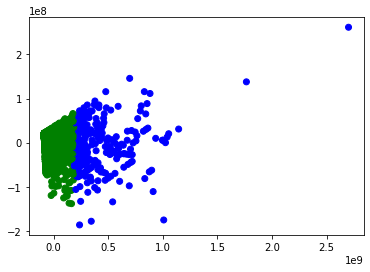

In [191]:
#Plot clustered movies after PCA
color_theme=np.array(['green','blue'])
plt.scatter(x=principal_df.pca1, y=principal_df.pca2, c=color_theme[clustering.labels_]) 

In [192]:
labels_df = pd.DataFrame({'clusterLabel': clustering.labels_})
small_medium_large_movies_f1 = small_medium_large_movies_f1.join(labels_df)
feature_selected = feature_selected.join(labels_df)
feature_selected

,cast_total_facebook_likes,imdb_score,budget,popularity,revenue,language_n,year_n,country_n,content_rating_n,director_name_n,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,clusterLabel
0,4834,7.9,2.370000e+08,185.071,2.787965e+09,1,5,1,1,5,...,0,0,0,0,1,0,0,0,0,1.0
1,48350,7.1,3.000000e+08,31.3637,9.610000e+08,1,5,1,1,5,...,0,0,0,0,0,0,0,0,0,1.0
2,1873,6.6,2.600000e+08,14.6704,2.841391e+08,1,5,1,1,3,...,0,0,0,0,1,0,0,0,0,1.0
3,46055,6.2,2.580000e+08,27.6143,8.908716e+08,1,5,1,1,6,...,0,0,0,1,1,0,1,0,0,1.0
5,2036,7.8,2.600000e+08,14.6848,5.917949e+08,1,5,1,2,1,...,1,0,0,1,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,1186,6.4,2.950113e+07,0.679528,0.000000e+00,1,5,1,0,1,...,0,0,0,0,0,0,0,0,0,NaN
5195,368,7.0,7.000000e+03,7.15307,4.247600e+05,1,5,1,1,1,...,0,0,0,0,1,0,1,0,0,NaN
5196,690,6.4,9.000000e+03,1.09048,0.000000e+00,1,5,1,10,3,...,0,0,0,0,0,0,0,0,0,NaN
5197,2386,6.3,2.950113e+07,0.907309,0.000000e+00,1,5,1,1,1,...,0,0,0,1,0,0,0,0,0,NaN


In [193]:
small_medium_large_movies_f1.to_csv("small_medium_large_movies_f1_v3.csv")

## Recommendation step

Suppose we need to recommend a number of movies that are similar to specific movie.
1. Compute distance between the film and each cluster (each center for each feature in the cluster)... pick the cluster with minimum distance.
2. Inside this cluster, apply cosine similarity to get the most similar films of that cluster.

### 1. Get the nearst cluster:

In [194]:
clustering.cluster_centers_.shape

(2, 39)

In [195]:
#Create dataframe to display clusters centroids
#Shapes of the output array is: (no. of features=25, no. of clusters=3)
centroids_df = pd.DataFrame(clustering.cluster_centers_)
centroids_df #rows: clusters, columns: features.

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,9365.279062,6.411099,2.889478e+07,7.968274,4.463123e+07,1.236345,4.728641,2.089286,3.153011,3.378151,...,0.049020,0.045168,0.115196,3.501401e-04,0.271709,0.127451,0.040266,0.321078,0.049370,0.019958
1,19538.226054,6.977011,1.107368e+08,19.073401,4.905842e+08,1.000000,4.854406,1.195402,1.919540,5.666667,...,0.015326,0.049808,0.080460,9.215718e-19,0.226054,0.291188,0.019157,0.306513,0.061303,0.007663


In [196]:
#Get data (features) of the movie that we want to recommend similar movies to it
movie_data = feature_selected.loc[ 1 , : ] #first movie
#Create a list for the data:
movie_data_list = []
movie_data_list.append(list(movie_data))
movie_data_list

[[48350,
  7.1,
  300000000.0,
  31.363664,
  961000000.0,
  1,
  5,
  1,
  1,
  5,
  27,
  7,
  3,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0]]

In [197]:
#Get data(features) of cluster_0
cluster0_data = list(clustering.cluster_centers_[0])

#Get data(features) of cluster_1
cluster1_data = list(clustering.cluster_centers_[1])

#Compute distance between the movie and centers of cluster's 0 features:
difference_0 = []
for i in range(len(movie_data_list)):
    difference_0.append((movie_data_list[i] - cluster0_data[i])**2) #because we have negative values

#Compute distance between the movie and centers of cluster's 1 features:
difference_1 = []
for i in range(len(movie_data_list)):
    difference_1.append((movie_data_list[i] - cluster1_data[i])**2) #because we have negative values


print(difference_0)
print(difference_1)

[array([1.51980847e+09, 8.75755153e+07, 8.99943809e+16, 8.71219767e+07,
       9.23503000e+17, 8.76897223e+07, 8.76148241e+07, 8.76897223e+07,
       8.76897223e+07, 8.76148241e+07, 8.72034558e+07, 8.75773870e+07,
       8.76522692e+07, 8.77084519e+07, 8.76897223e+07, 8.76897223e+07,
       8.77084519e+07, 8.77084519e+07, 8.77084519e+07, 8.76897223e+07,
       8.77084519e+07, 8.77084519e+07, 8.77084519e+07, 8.77084519e+07,
       8.76897223e+07, 8.77084519e+07, 8.77084519e+07, 8.77084519e+07,
       8.77084519e+07, 8.77084519e+07, 8.77084519e+07, 8.77084519e+07,
       8.77084519e+07, 8.77084519e+07, 8.77084519e+07, 8.77084519e+07,
       8.77084519e+07, 8.77084519e+07, 8.77084519e+07, 8.76897223e+07])]
[array([8.30118318e+08, 3.81464885e+08, 8.99882774e+16, 3.80517680e+08,
       9.23483448e+17, 3.81703202e+08, 3.81546920e+08, 3.81703202e+08,
       3.81703202e+08, 3.81546920e+08, 3.80687942e+08, 3.81468791e+08,
       3.81625057e+08, 3.81742277e+08, 3.81703202e+08, 3.81703202e+08,
  

In [198]:
#Sum all distances in both output lists:
sum_0 = np.sum(difference_0)
sum_1 = np.sum(difference_1) 
print(sum_0)
print(sum_1)

#Compute min distance which corresponds to closest cluster
min_distance = min(sum_0, sum_1)
if (min_distance == sum_0):
  print("Cluster_0 is closer")
elif (min_distance == sum_1):
  print("Cluster_1 is closer")

print("min_distance = ", min_distance)

1.0134973857048957e+18
1.0134717403083098e+18
Cluster_1 is closer
min_distance =  1.0134717403083098e+18


### 2. Get cosine similarity between the input movie and the movies inside the closer cluster

In [199]:
from sklearn.metrics.pairwise import cosine_similarity

print("The name of the movie: {}.\nThe genres are: {}".format(small_medium_large_movies_f1.iloc[0]['title'], 
                                                              small_medium_large_movies_f1.iloc[0]['genres']))
cos_sim = cosine_similarity(feature_selected.loc[feature_selected['clusterLabel'] == 1]) 

#Similarity bestween the input movie and all movies in cluster_1
#Get movieId for tge top 5 most similar movies to first film

#[::-1] to reverse the list(min -> max), [-5] to return top similar movies, a
# rgsort: returns indices of sorted items in the list

neighbors = np.argsort(cos_sim[0])[-5:][::-1] 

print("movies indices for top similar movies to first movie:", neighbors)

print("Similars movies are:")
similar_movies = [(small_medium_large_movies_f1.loc[small_medium_large_movies_f1['clusterLabel'] == 1].iloc[i]['title'],
                      small_medium_large_movies_f1.loc[small_medium_large_movies_f1['clusterLabel'] == 1].iloc[i]['genres'])
                  for i in neighbors]

for movie, genres in similar_movies:
    print("{} --> {}".format(movie[1:], genres[1:]))

The name of the movie: Avatar.
The genres are: Action|Adventure|Sci-Fi|IMAX|Fantasy
movies indices for top similar movies to first movie: [ 0 12 13 78 65]
Similars movies are:
vatar --> ction|Adventure|Sci-Fi|IMAX|Fantasy
ing Kong --> ction|Adventure|Romance|Fantasy|Horror|Drama
itanic --> omance|Drama
ex and the City --> omance|Comedy
inderella --> hildren|Musical|Animation|Romance|Fantasy|Family|Drama


In [200]:
small_medium_large_movies_f1

,director_name,actor_2_name,actor_1_name,clean_title,cast_total_facebook_likes,actor_3_name,language,country,content_rating,imdb_score,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,clusterLabel
0,James Cameron,Joel David Moore,CCH Pounder,avatar,4834,Wes Studi,English,USA,PG-13,7.9,...,0,0,0,0,1,0,0,0,0,1.0
1,Gore Verbinski,Orlando Bloom,Johnny Depp,pirates of the caribbean: at world's end,48350,Jack Davenport,English,USA,PG-13,7.1,...,0,0,0,0,0,0,0,0,0,1.0
2,Andrew Stanton,Samantha Morton,Daryl Sabara,john carter,1873,Polly Walker,English,USA,PG-13,6.6,...,0,0,0,0,1,0,0,0,0,1.0
3,Sam Raimi,James Franco,J.K. Simmons,spider-man 3,46055,Kirsten Dunst,English,USA,PG-13,6.2,...,0,0,0,1,1,0,1,0,0,1.0
5,Nathan Greno,Donna Murphy,Brad Garrett,tangled,2036,M.C. Gainey,English,USA,PG,7.8,...,1,0,0,1,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,Ash Baron-Cohen,Stanley B. Herman,Peter Greene,bang,1186,James Noble,English,USA,missing,6.4,...,0,0,0,0,0,0,0,0,0,NaN
5195,Shane Carruth,David Sullivan,Shane Carruth,primer,368,Casey Gooden,English,USA,PG-13,7.0,...,0,0,0,0,1,0,1,0,0,NaN
5196,Edward Burns,Caitlin FitzGerald,Kerry Bishé,newlyweds,690,Daniella Pineda,English,USA,Not Rated,6.4,...,0,0,0,0,0,0,0,0,0,NaN
5197,Daniel Hsia,Daniel Henney,Alan Ruck,shanghai calling,2386,Eliza Coupe,English,USA,PG-13,6.3,...,0,0,0,1,0,0,0,0,0,NaN


### Create a function for the KMeans model

In [223]:
from sklearn.metrics.pairwise import cosine_similarity
def getNeighbors_KMeans(data, movieId, K):
    
    columns=['director_name', 'actor_2_name', 'actor_1_name', 
             'clean_title', 'actor_3_name', 'language', 'country','content_rating', 
             'genres', 'year', 'movieId', 'original_title', 'title', 'clusterLabel']
    
    # Centroids of trained clusters
    centroids = np.array([[9.36527906e+03, 6.41109944e+00, 2.88947752e+07, 7.96827436e+00,
        4.46312346e+07, 1.23634454e+00, 4.72864146e+00, 2.08928571e+00,
        3.15301120e+00, 3.37815126e+00, 8.62990196e+00, 4.79061625e+00,
        3.07142857e+00, 1.40056022e-03, 2.46848739e-01, 1.61414566e-01,
        3.36134454e-02, 6.47759104e-02, 5.60224090e-02, 4.34523810e-01,
        2.24789916e-01, 2.48599440e-02, 5.92787115e-01, 8.71848739e-02,
        1.11694678e-01, 5.60224090e-03, 3.88655462e-02, 1.17647059e-01,
        1.54061625e-02, 4.90196078e-02, 4.51680672e-02, 1.15196078e-01,
        3.50140056e-04, 2.71708683e-01, 1.27450980e-01, 4.02661064e-02,
        3.21078431e-01, 4.93697479e-02, 1.99579832e-02],
       [1.95382261e+04, 6.97701149e+00, 1.10736782e+08, 1.90734009e+01,
        4.90584232e+08, 1.00000000e+00, 4.85440613e+00, 1.19540230e+00,
        1.91954023e+00, 5.66666667e+00, 1.34022989e+01, 7.24137931e+00,
        5.36015326e+00, 3.68628739e-18, 5.44061303e-01, 6.70498084e-01,
        2.10727969e-01, 1.91570881e-02, 2.14559387e-01, 4.36781609e-01,
        1.45593870e-01, 6.59194921e-17, 2.95019157e-01, 2.95019157e-01,
        2.95019157e-01, 1.47451495e-17, 2.68199234e-02, 2.68199234e-02,
        2.49042146e-01, 1.53256705e-02, 4.98084291e-02, 8.04597701e-02,
        9.21571847e-19, 2.26053640e-01, 2.91187739e-01, 1.91570881e-02,
        3.06513410e-01, 6.13026820e-02, 7.66283525e-03]])
    
    #Drop 2 columns from the labeled_genres_new_df dataFrame
    movie_data = data[data['movieId'] == movieId].drop(columns, axis=1).to_numpy()

    #Compute distance between the movie and cluster_0
    diff0 = np.sum(np.power((movie_data - centroids[0]), 2))

    #Compute distance between the movie and cluster_1
    diff1 = np.sum(np.power((movie_data - centroids[1]), 2))
  
    #Get the label of closet cluster
    cloest_clusterLabel = np.argmin([diff0, diff1])

    #Return movies inside the closest cluster
    selected_data = data[data['clusterLabel'] == cloest_clusterLabel].drop(columns, axis=1)
  
    #Compute the cosine similarity between the movie and movies inside the closest cluster
    cos_sim = cosine_similarity(movie_data, selected_data)
    
    # Get movies indicies for tge top K most similar movies to first film.
    # [::-1] to reverse the list(min -> max), [-K] to return top similar movies, argsort: 
    # returns indices of sorted items in the list.
    neighbors_indicies = np.argsort(cos_sim[0])[-K:][::-1]
   
    for i in neighbors_indicies:
        result = [data[data['clusterLabel'] == cloest_clusterLabel].iloc[i] for i in neighbors_indicies]
        
    parsed_result = []
    for item in result:
        parsed_result.append({"movieId": str(item["movieId"]), "title": item["title"], "genres": item["genres"]})
        print("Movie name: {}.\ngenres: {}.".format(item['title'], item['genres']))
    try:
        return json.dumps(parsed_result)
    except FileNotFoundError:
        abort(404)

#Calling the function:
getNeighbors_KMeans(small_medium_large_movies_f1, 53125, 5)

Movie name: Pirates of the Caribbean: At World's End.
genres: Adventure|Comedy|Fantasy|Action.
Movie name: Species.
genres: Sci-Fi|Thriller|Horror|Action.
Movie name: Iron Man 2.
genres: Action|Adventure|Sci-Fi|IMAX|Thriller.
Movie name: Die Hard 2.
genres: Adventure|Thriller|Action.
Movie name: How to Train Your Dragon.
genres: Adventure|Children|Animation|IMAX|Fantasy|Family.


'[{"movieId": "53125", "title": "Pirates of the Caribbean: At World\'s End", "genres": "Adventure|Comedy|Fantasy|Action"}, {"movieId": "196", "title": "Species", "genres": "Sci-Fi|Thriller|Horror|Action"}, {"movieId": "77561", "title": "Iron Man 2", "genres": "Action|Adventure|Sci-Fi|IMAX|Thriller"}, {"movieId": "1370", "title": "Die Hard 2", "genres": "Adventure|Thriller|Action"}, {"movieId": "76093", "title": "How to Train Your Dragon", "genres": "Adventure|Children|Animation|IMAX|Fantasy|Family"}]'

# ============================================================

# Transformation (2)
One hote encoding

In [202]:
small_medium_large_movies_f1.columns

Index(['director_name', 'actor_2_name', 'actor_1_name', 'clean_title',
       'cast_total_facebook_likes', 'actor_3_name', 'language', 'country',
       'content_rating', 'imdb_score', 'movieId', 'year', 'genres', 'budget',
       'original_title', 'popularity', 'revenue', 'title', 'language_n',
       'year_n', 'country_n', 'content_rating_n', 'director_name_n',
       'actor_1_name_n', 'actor_2_name_n', 'actor_3_name_n',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Biography',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Film-Noir', 'History', 'Horror', 'IMAX', 'Music', 'Musical',
       'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', 'clusterLabel'],
      dtype='object')

**language**

In [203]:
language_encoding = pd.get_dummies(small_medium_large_movies_f1.language.str.lower())
language_encoding.columns

Index(['aboriginal', 'arabic', 'bosnian', 'cantonese', 'dari', 'dutch',
       'english', 'filipino', 'français', 'french', 'german', 'hindi',
       'icelandic', 'italian', 'japanese', 'korean', 'mandarin', 'maya',
       'no language', 'none', 'norwegian', 'persian', 'polish', 'portuguese',
       'russian', 'spanish', 'swedish', 'vietnamese', 'zulu'],
      dtype='object')

Let's replace the language with a number from the dict_lang.

**Year**

In [204]:
small_medium_large_movies_f1['year'] = small_medium_large_movies_f1['year'].astype('int32')
print("The minimum year is {}".format(small_medium_large_movies_f1['year'].min()))
print("The maximum year is {}".format(small_medium_large_movies_f1['year'].max()))
print("The range of years is {}".format(small_medium_large_movies_f1['year'].max() - small_medium_large_movies_f1['year'].min()))

The minimum year is 1915
The maximum year is 2015
The range of years is 100


In [205]:
#let's categorize this range of years into 5 classes.
def transform_year(year):
    if year < 1915:
        return 0
    elif year >= 1915 and year < 1935:
        return 1
    elif year >= 1935 and year < 1955:
        return 2
    elif year >= 1955 and year < 1975:
        return 3
    elif year >= 1975 and year < 1995:
        return 4
    elif year >= 1995 and year < 2015:
        return 5
    else:
        return 6
        
    
small_medium_large_movies_f1['year_n'] = small_medium_large_movies_f1['year'].apply(transform_year)

small_medium_large_movies_f1['year_n']

0       5
1       5
2       5
3       5
5       5
       ..
5194    5
5195    5
5196    5
5197    5
5198    5
Name: year_n, Length: 3117, dtype: int64

In [206]:
year_encoding = pd.get_dummies(small_medium_large_movies_f1['year_n'])
year_encoding

,1,2,3,4,5,6
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
5,0,0,0,0,1,0
...,...,...,...,...,...,...
5194,0,0,0,0,1,0
5195,0,0,0,0,1,0
5196,0,0,0,0,1,0
5197,0,0,0,0,1,0


**Country**

In [207]:
country_encoding = pd.get_dummies(small_medium_large_movies_f1.country.str.lower(), dummy_na=True)
country_encoding

,afghanistan,aruba,australia,bahamas,brazil,canada,china,czech republic,denmark,france,...,russia,south africa,south korea,soviet union,spain,sweden,switzerland,uk,usa,NaN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


**content_rating**

In [208]:
content_rating_encoding = pd.get_dummies(small_medium_large_movies_f1.content_rating.str.lower(), dummy_na=True)
content_rating_encoding

,approved,g,gp,m,missing,nc-17,not rated,passed,pg,pg-13,r,tv-14,tv-g,tv-ma,tv-pg,tv-y,unrated,x,NaN
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5195,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5196,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5197,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


**director_name, actor_1_name, actor_2_name, actor_3_name.**

In [209]:
directors = small_medium_large_movies_f1['director_name']
print("The number of unique of directors is {}".format(len(directors.unique())))

actors_1 = small_medium_large_movies_f1['actor_1_name']
print("The number of unique actor_1_name is {}".format(len(actors_1.unique())))

actors_2 = small_medium_large_movies_f1['actor_2_name']
print("The number of unique of actor_2_name is {}".format(len(actors_2.unique())))

actors_3 = small_medium_large_movies_f1['actor_3_name']
print("The number of unique of actor_3_name is {}".format(len(actors_3.unique())))

The number of unique of directors is 1620
The number of unique actor_1_name is 1398
The number of unique of actor_2_name is 2031
The number of unique of actor_3_name is 2343


In [210]:
actors_1 = small_medium_large_movies_f1[['actor_1_name']].rename(columns={"actor_1_name": "actor_name"})
actors_2 = small_medium_large_movies_f1[['actor_2_name']].rename(columns={"actor_2_name": "actor_name"})
actors_3 = small_medium_large_movies_f1[['actor_3_name']].rename(columns={"actor_3_name": "actor_name"})

actors = actors_1.append(actors_2)
actors = actors.append(actors_3)

actors_encoding = pd.get_dummies(actors.actor_name.str.lower())
actors_encoding

,50 cent,a. michael baldwin,a.j. buckley,a.j. langer,aaliyah,aaron hill,aaron hughes,aaron stanford,aaron staton,aaron yoo,...,zoe levin,zoe lister-jones,zoe ventoura,zoey deutch,zooey deschanel,zoë bell,zoë kravitz,zubaida sahar,ólafur darri ólafsson,óscar jaenada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [211]:
directors_encoding = pd.get_dummies(small_medium_large_movies_f1.director_name.str.lower())
directors_encoding

,aaron schneider,aaron seltzer,adam brooks,adam carolla,adam goldberg,adam green,adam jay epstein,adam marcus,adam mckay,adam rapp,...,yimou zhang,youssef delara,zach braff,zach cregger,zack snyder,zack ward,zak penn,zal batmanglij,émile gaudreault,étienne faure
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [212]:
# Let's append data vertical

small_medium_large_movies_f1_encoding = pd.concat([small_medium_large_movies_f1,language_encoding, 
                                                   country_encoding, year_encoding, directors_encoding, 
                                                   content_rating_encoding, actors_encoding[0:3117], 
                                                   actors_encoding[3117:6234], actors_encoding[6234:]], axis=1)

small_medium_large_movies_f1_encoding



,director_name,actor_2_name,actor_1_name,clean_title,cast_total_facebook_likes,actor_3_name,language,country,content_rating,imdb_score,...,zoe levin,zoe lister-jones,zoe ventoura,zoey deutch,zooey deschanel,zoë bell,zoë kravitz,zubaida sahar,ólafur darri ólafsson,óscar jaenada
0,James Cameron,Joel David Moore,CCH Pounder,avatar,4834,Wes Studi,English,USA,PG-13,7.9,...,0,0,0,0,0,0,0,0,0,0
1,Gore Verbinski,Orlando Bloom,Johnny Depp,pirates of the caribbean: at world's end,48350,Jack Davenport,English,USA,PG-13,7.1,...,0,0,0,0,0,0,0,0,0,0
2,Andrew Stanton,Samantha Morton,Daryl Sabara,john carter,1873,Polly Walker,English,USA,PG-13,6.6,...,0,0,0,0,0,0,0,0,0,0
3,Sam Raimi,James Franco,J.K. Simmons,spider-man 3,46055,Kirsten Dunst,English,USA,PG-13,6.2,...,0,0,0,0,0,0,0,0,0,0
5,Nathan Greno,Donna Murphy,Brad Garrett,tangled,2036,M.C. Gainey,English,USA,PG,7.8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,Ash Baron-Cohen,Stanley B. Herman,Peter Greene,bang,1186,James Noble,English,USA,missing,6.4,...,0,0,0,0,0,0,0,0,0,0
5195,Shane Carruth,David Sullivan,Shane Carruth,primer,368,Casey Gooden,English,USA,PG-13,7.0,...,0,0,0,0,0,0,0,0,0,0
5196,Edward Burns,Caitlin FitzGerald,Kerry Bishé,newlyweds,690,Daniella Pineda,English,USA,Not Rated,6.4,...,0,0,0,0,0,0,0,0,0,0
5197,Daniel Hsia,Daniel Henney,Alan Ruck,shanghai calling,2386,Eliza Coupe,English,USA,PG-13,6.3,...,0,0,0,0,0,0,0,0,0,0


In [213]:
small_medium_large_movies_f1_encoding.to_csv('small_medium_large_movies_f1_encoding.csv')

In [214]:
columns_to_remove = ['director_name', 'actor_2_name', 'actor_1_name', 'clean_title',
       'actor_3_name', 'language', 'country',
       'content_rating', 'movieId', 'year', 'genres',
       'original_title','title', 'language_n','clusterLabel',
       'year_n', 'country_n', 'content_rating_n', 'director_name_n',
       'actor_1_name_n', 'actor_2_name_n', 'actor_3_name_n',
       ]

In [215]:
#Set range of possible k values, from 2 to length of dataset (suppose each point'll represent a single cluster), step 10 to speed the test up.
feature_selected_2 = small_medium_large_movies_f1_encoding.drop(columns=columns_to_remove)
possible_k_values = range(2, len(feature_selected_2), 1)

for k in possible_k_values:
    score = clustering_errors(k, feature_selected_2)
    print("For k = {}, silhouette score is {}".format(k, score))

For k = 2, silhouette score is 0.7912517519836988
For k = 3, silhouette score is 0.7109788372483622
For k = 4, silhouette score is 0.6465140850578386
For k = 5, silhouette score is 0.6468223257398846
For k = 6, silhouette score is 0.6171756984589212
For k = 7, silhouette score is 0.5681311177841681
For k = 8, silhouette score is 0.5563909452386423
For k = 9, silhouette score is 0.4939243165473749
For k = 10, silhouette score is 0.49379406689729965
For k = 11, silhouette score is 0.4292391049476175
For k = 12, silhouette score is 0.44380432045254414


KeyboardInterrupt: 

In [216]:
#Build and run the model
from sklearn.cluster import KMeans
clustering_2 = KMeans(n_clusters=2) #According to the elbow_method result
clustering_2.fit(feature_selected_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [217]:
#Print the clustering labels for each movie
print("Movies labels after clustering: ", clustering_2.labels_)
print("Length of labeled data: ", clustering_2.labels_.shape)
print("Type of output: ", type(clustering_2.labels_))

Movies labels after clustering:  [1 1 1 ... 0 0 0]
Length of labeled data:  (3117,)
Type of output:  <class 'numpy.ndarray'>


In [218]:
#Calling the fuction and print dataframe after applying dimension reduction using PCA:
principal_df_2 = reduce_data(feature_selected_2, 2, ["pca1", "pca2"])
principal_df_2.head(5)

,pca1,pca2
0,2.700825e+09,2.616105e+08
1,9.111515e+08,-1.110000e+08
2,2.373405e+08,-1.866273e+08
3,8.349048e+08,-8.153074e+07
4,5.405198e+08,-1.343354e+08


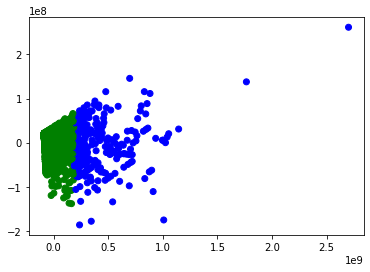

In [219]:
#Plot clustered movies after PCA
color_theme=np.array(['green','blue'])
plt.scatter(x=principal_df_2.pca1, y=principal_df_2.pca2, c=color_theme[clustering_2.labels_]) 

In [220]:
labels_df = pd.DataFrame({'clusterLabel_2': clustering_2.labels_})
small_medium_large_movies_f1_encoding = small_medium_large_movies_f1_encoding.join(labels_df)
feature_selected_2 = feature_selected_2.join(labels_df)
feature_selected_2

,cast_total_facebook_likes,imdb_score,budget,popularity,revenue,(no genres listed),Action,Adventure,Animation,Biography,...,zoe lister-jones,zoe ventoura,zoey deutch,zooey deschanel,zoë bell,zoë kravitz,zubaida sahar,ólafur darri ólafsson,óscar jaenada,clusterLabel_2
0,4834,7.9,2.370000e+08,185.071,2.787965e+09,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,48350,7.1,3.000000e+08,31.3637,9.610000e+08,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,1873,6.6,2.600000e+08,14.6704,2.841391e+08,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,46055,6.2,2.580000e+08,27.6143,8.908716e+08,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1.0
5,2036,7.8,2.600000e+08,14.6848,5.917949e+08,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,1186,6.4,2.950113e+07,0.679528,0.000000e+00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5195,368,7.0,7.000000e+03,7.15307,4.247600e+05,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5196,690,6.4,9.000000e+03,1.09048,0.000000e+00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5197,2386,6.3,2.950113e+07,0.907309,0.000000e+00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [221]:
centroids_2 = clustering_2.cluster_centers_

In [222]:
from sklearn.metrics.pairwise import cosine_similarity
def getNeighbors_KMeans(data, movieId, K):
    
    columns_to_remove = ['director_name', 'actor_2_name', 'actor_1_name', 'clean_title',
       'actor_3_name', 'language', 'country',
       'content_rating', 'movieId', 'year', 'genres',
       'original_title','title', 'language_n','clusterLabel','clusterLabel_2',
       'year_n', 'country_n', 'content_rating_n', 'director_name_n',
       'actor_1_name_n', 'actor_2_name_n', 'actor_3_name_n',
       ]
    
    #Drop 2 columns from the labeled_genres_new_df dataFrame
    movie_data = data[data['movieId'] == movieId].drop(columns_to_remove, axis=1).to_numpy()

    print("movie name: {}.\ngenres: {}".format(data[data['movieId'] == movieId]['title'], data[data['movieId'] == movieId]['genres']))
    #Compute distance between the movie and cluster_0
    diff0 = np.sum(np.power((movie_data - centroids_2[0]), 2))

    #Compute distance between the movie and cluster_1
    diff1 = np.sum(np.power((movie_data - centroids_2[1]), 2))
  
    #Get the label of closet cluster
    cloest_clusterLabel = np.argmin([diff0, diff1])

    #Return movies inside the closest cluster
    selected_data = data[data['clusterLabel_2'] == cloest_clusterLabel].drop(columns_to_remove, axis=1)
  
    #Compute the cosine similarity between the movie and movies inside the closest cluster
    cos_sim = cosine_similarity(movie_data, selected_data)
    
    # Get movies indicies for tge top K most similar movies to first film.
    # [::-1] to reverse the list(min -> max), [-K] to return top similar movies, argsort: 
    # returns indices of sorted items in the list.
    neighbors_indicies = np.argsort(cos_sim[0])[-K:][::-1]
   
    for i in neighbors_indicies:
        result = [data[data['clusterLabel_2'] == cloest_clusterLabel].iloc[i] for i in neighbors_indicies]
        
    parsed_result = []
    for item in result:
        parsed_result.append({"movieId": str(item["movieId"]), "title": item["title"], "genres": item["genres"]})
        print("Movie name: {}.\ngenres: {}.".format(item['title'], item['genres']))
    try:
        return json.dumps(parsed_result)
    except FileNotFoundError:
        abort(404)

#Calling the function:
getNeighbors_KMeans(small_medium_large_movies_f1_encoding, 53125, 5)

movie name: 1    Pirates of the Caribbean: At World's End
Name: title, dtype: object.
genres: 1    Adventure|Comedy|Fantasy|Action
Name: genres, dtype: object
Movie name: Pirates of the Caribbean: At World's End.
genres: Adventure|Comedy|Fantasy|Action.
Movie name: Species.
genres: Sci-Fi|Thriller|Horror|Action.
Movie name: Iron Man 2.
genres: Action|Adventure|Sci-Fi|IMAX|Thriller.
Movie name: Die Hard 2.
genres: Adventure|Thriller|Action.
Movie name: How to Train Your Dragon.
genres: Adventure|Children|Animation|IMAX|Fantasy|Family.


'[{"movieId": "53125", "title": "Pirates of the Caribbean: At World\'s End", "genres": "Adventure|Comedy|Fantasy|Action"}, {"movieId": "196", "title": "Species", "genres": "Sci-Fi|Thriller|Horror|Action"}, {"movieId": "77561", "title": "Iron Man 2", "genres": "Action|Adventure|Sci-Fi|IMAX|Thriller"}, {"movieId": "1370", "title": "Die Hard 2", "genres": "Adventure|Thriller|Action"}, {"movieId": "76093", "title": "How to Train Your Dragon", "genres": "Adventure|Children|Animation|IMAX|Fantasy|Family"}]'

# ================================================